## Check heatmap of generator

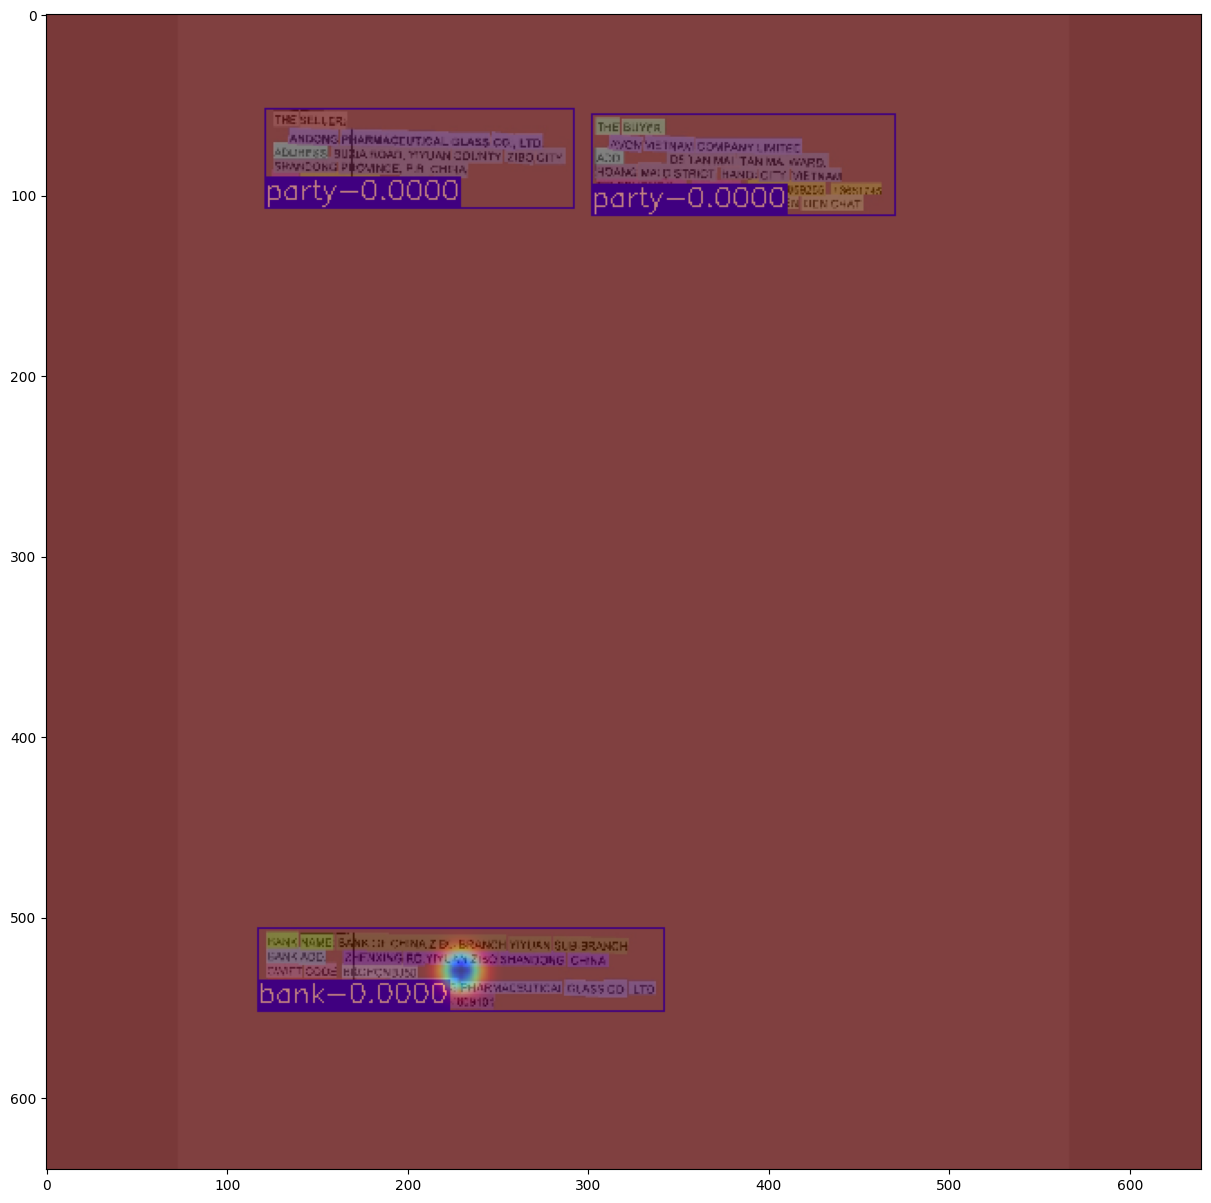

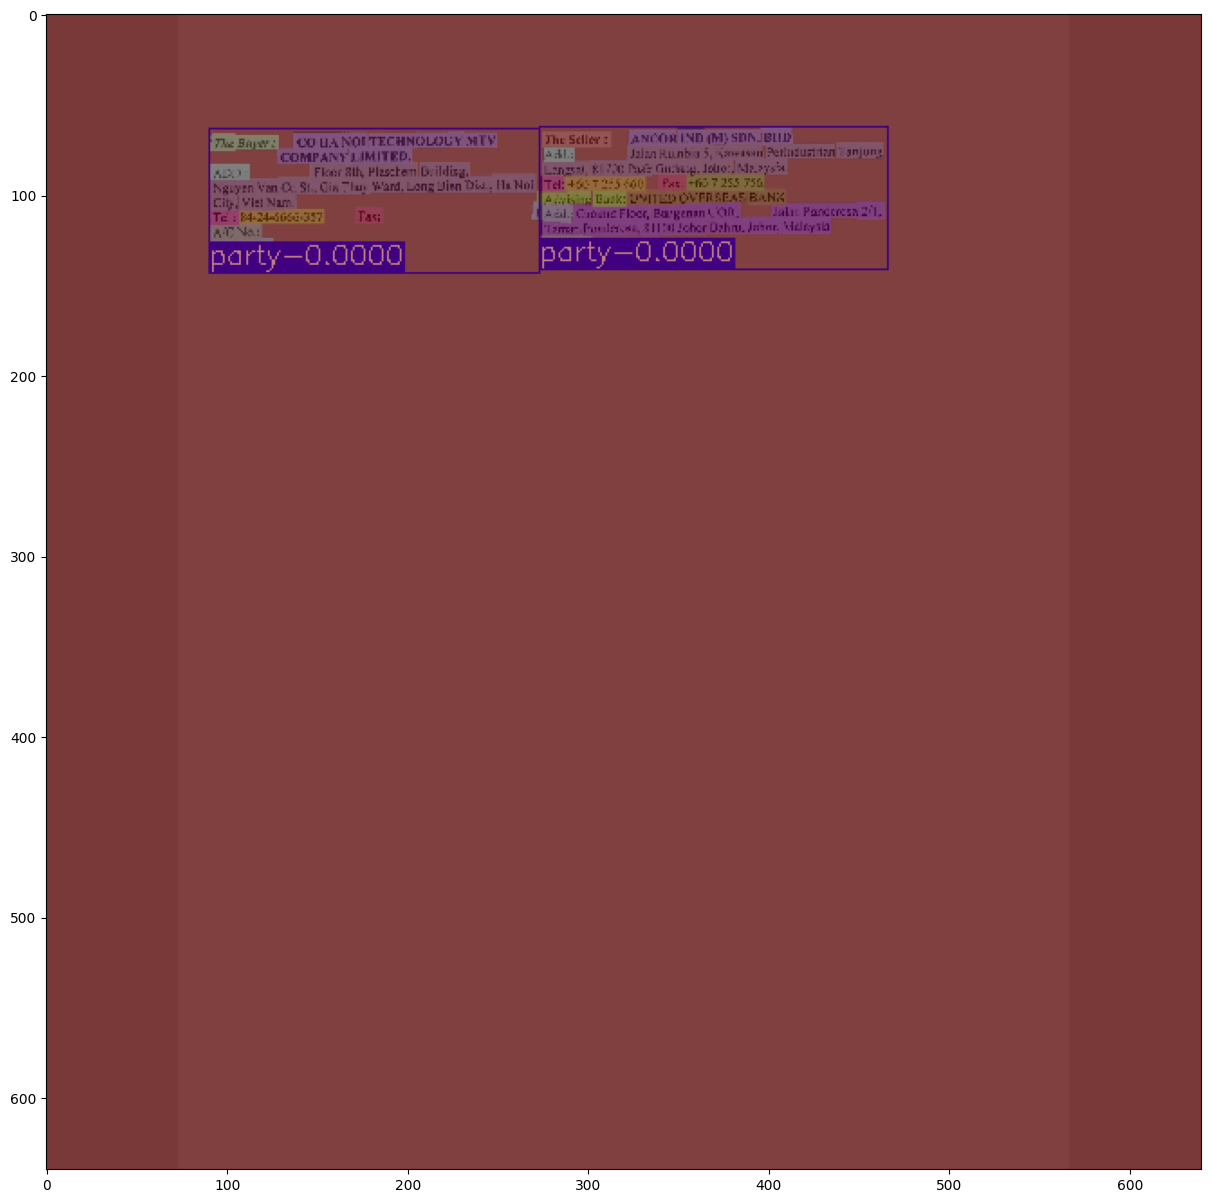

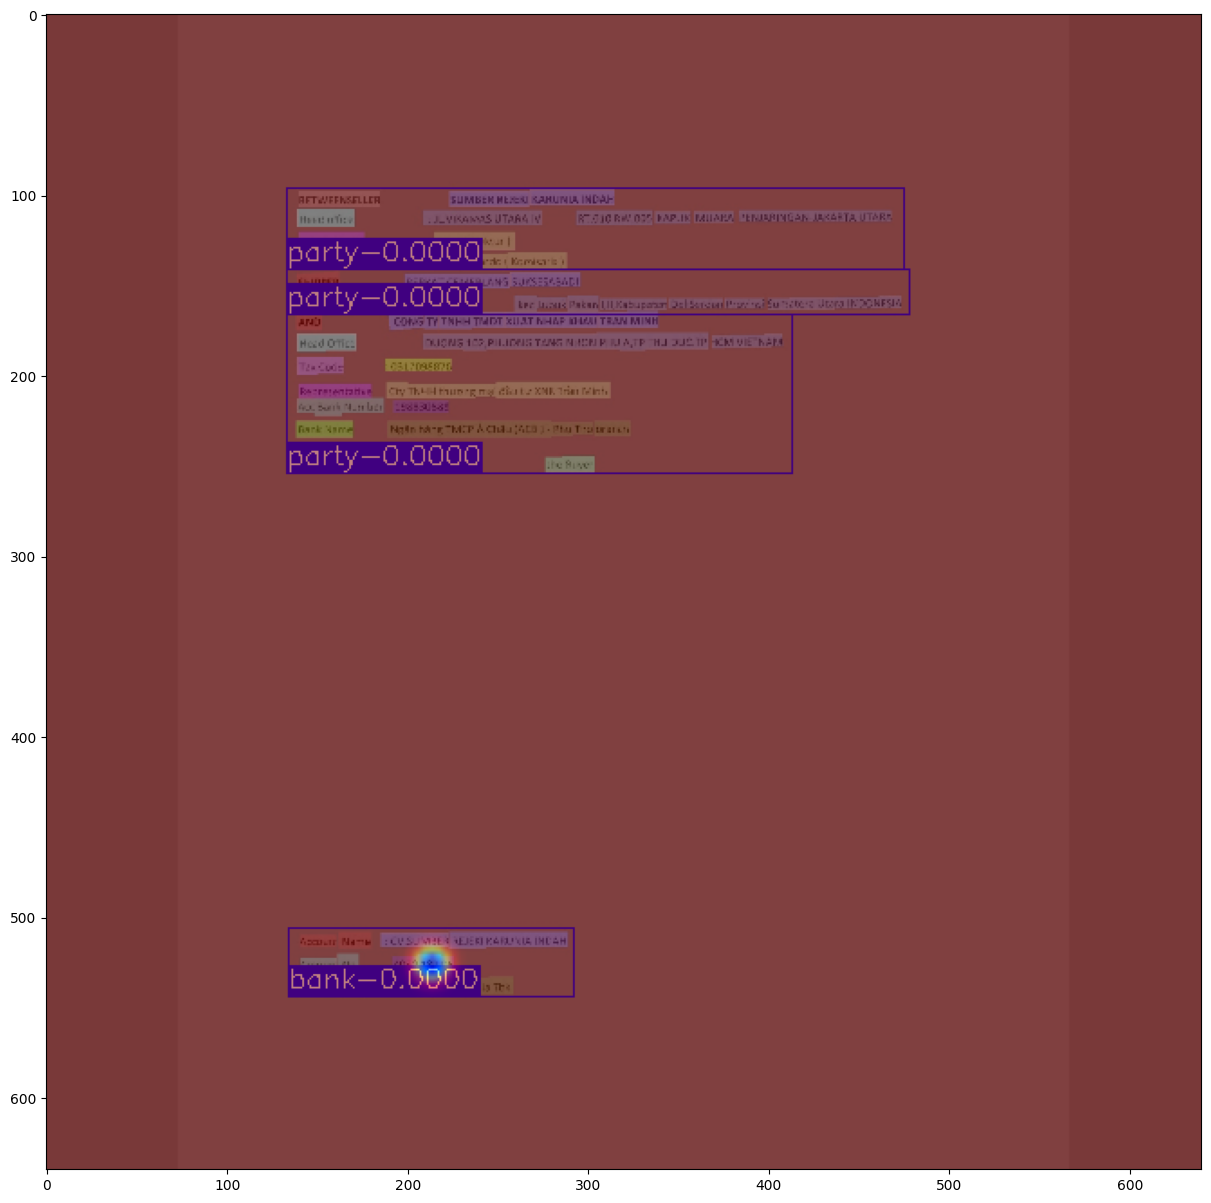

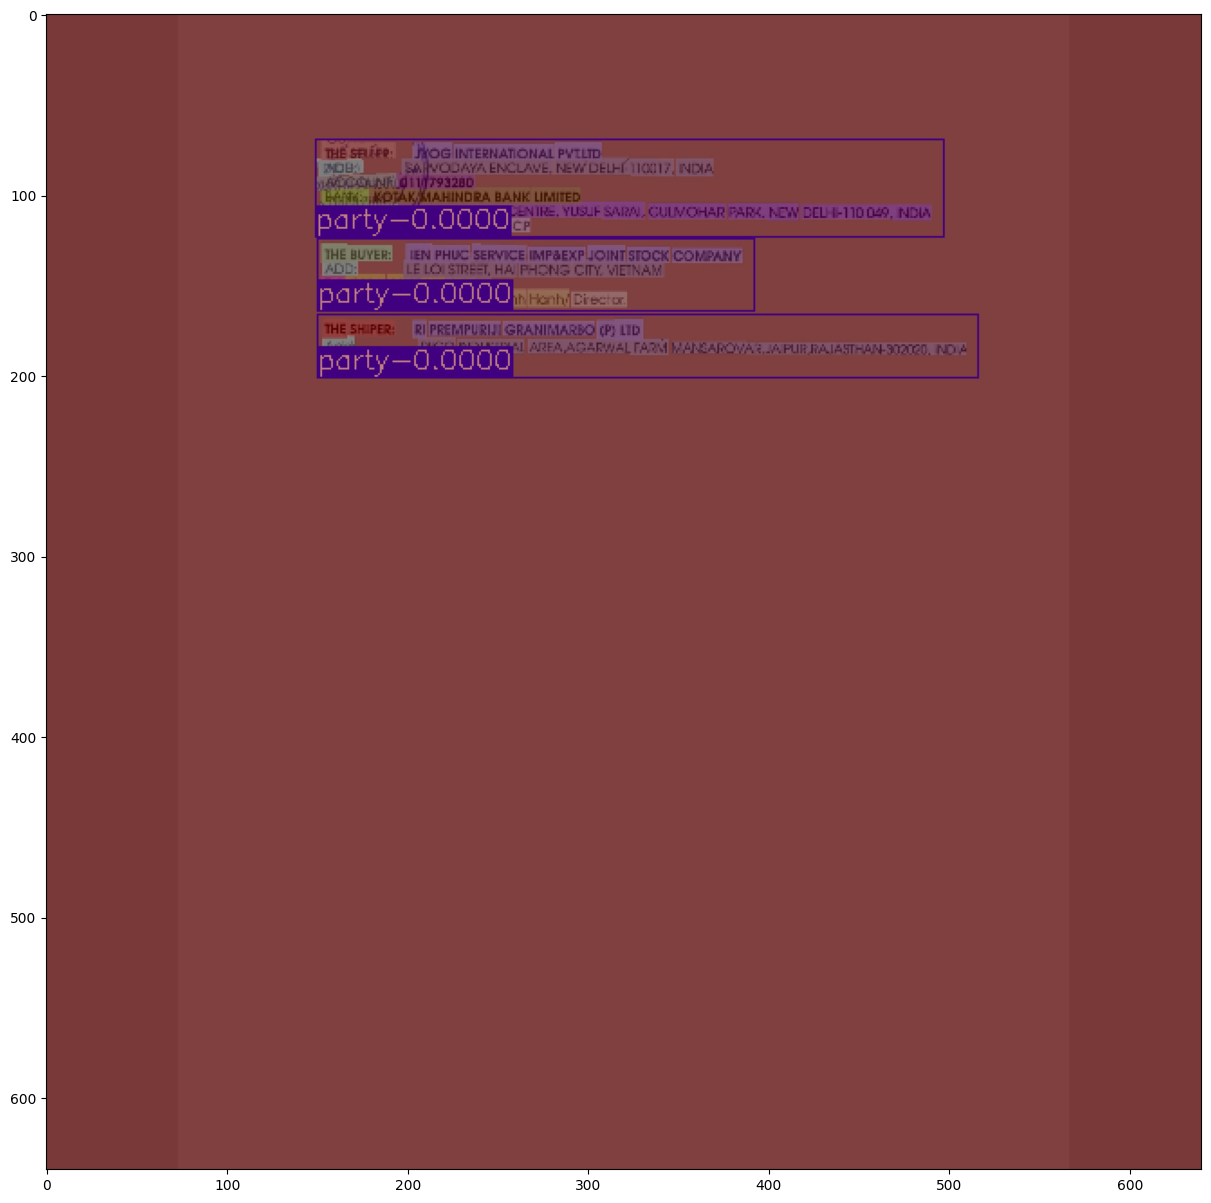

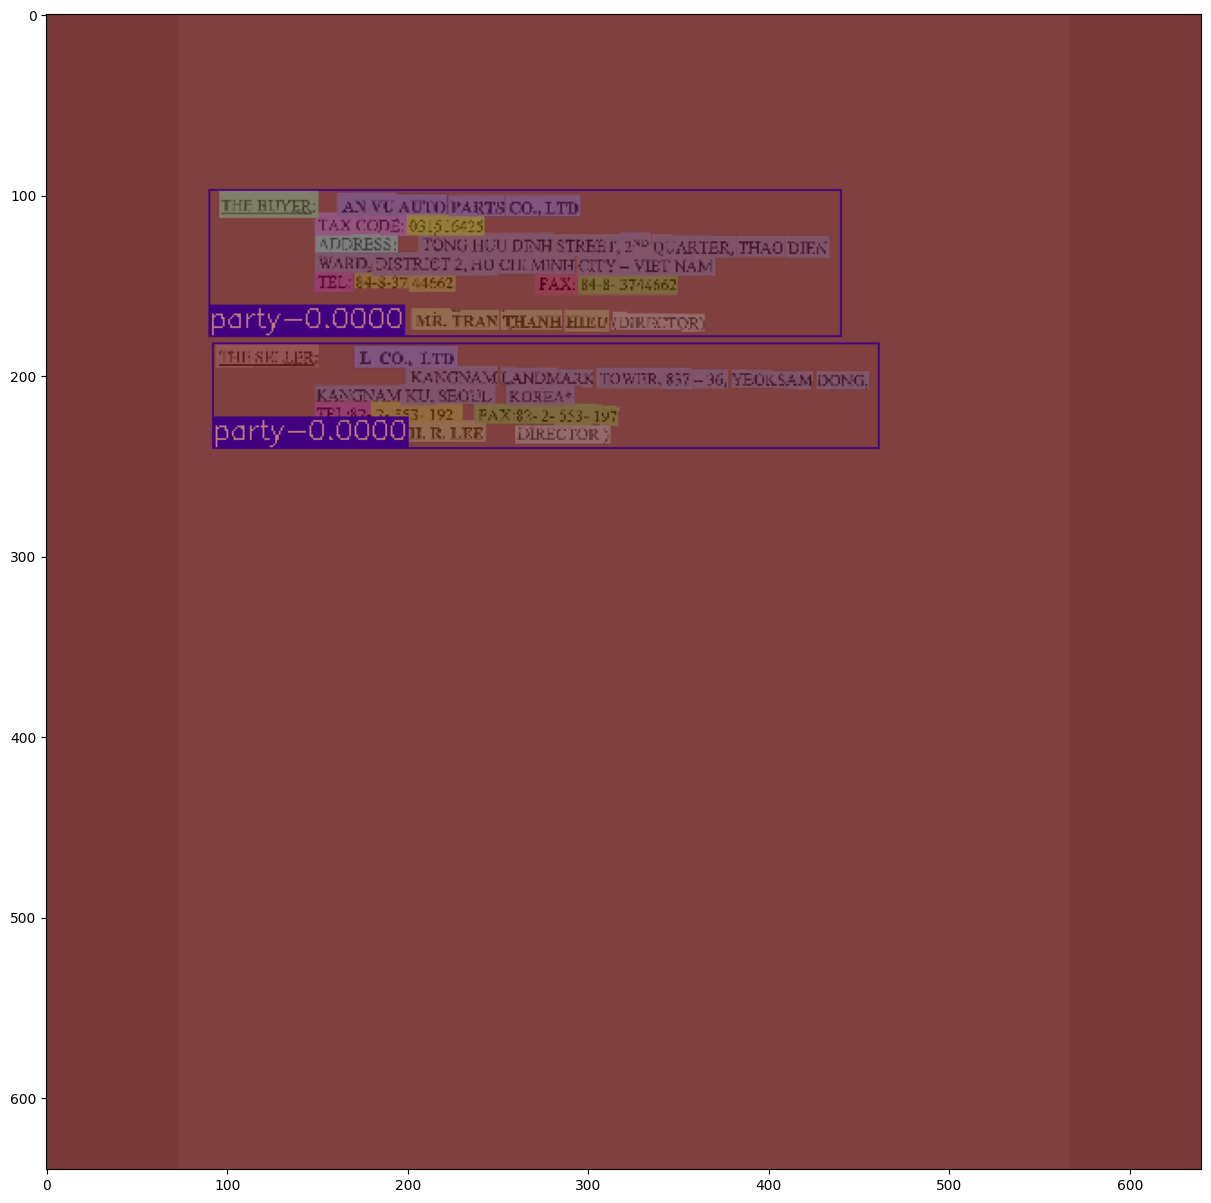

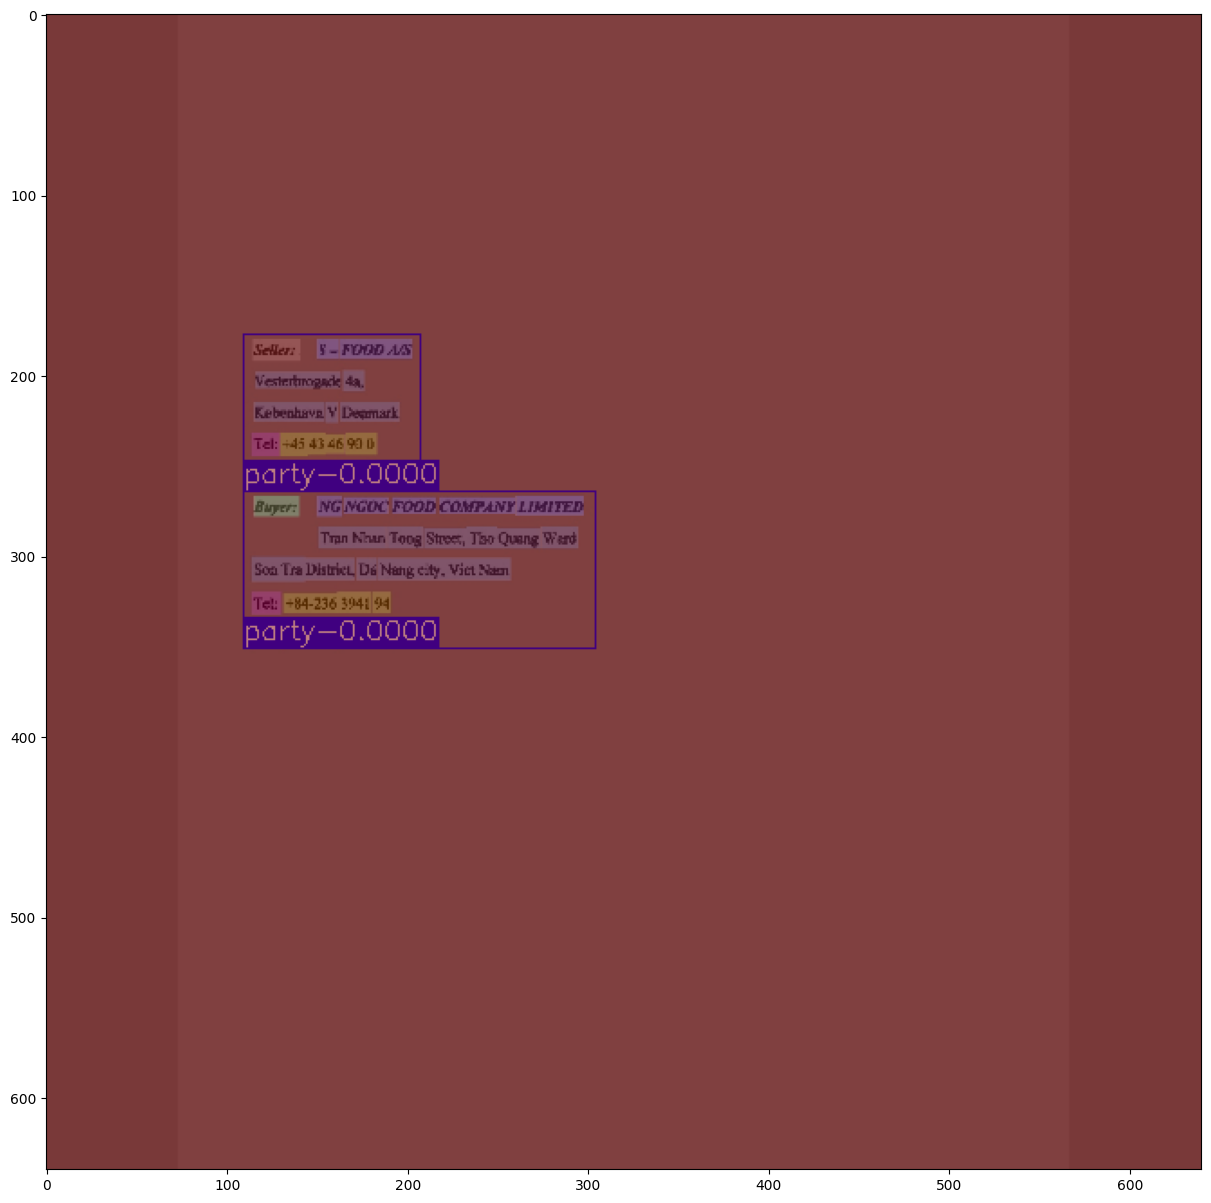

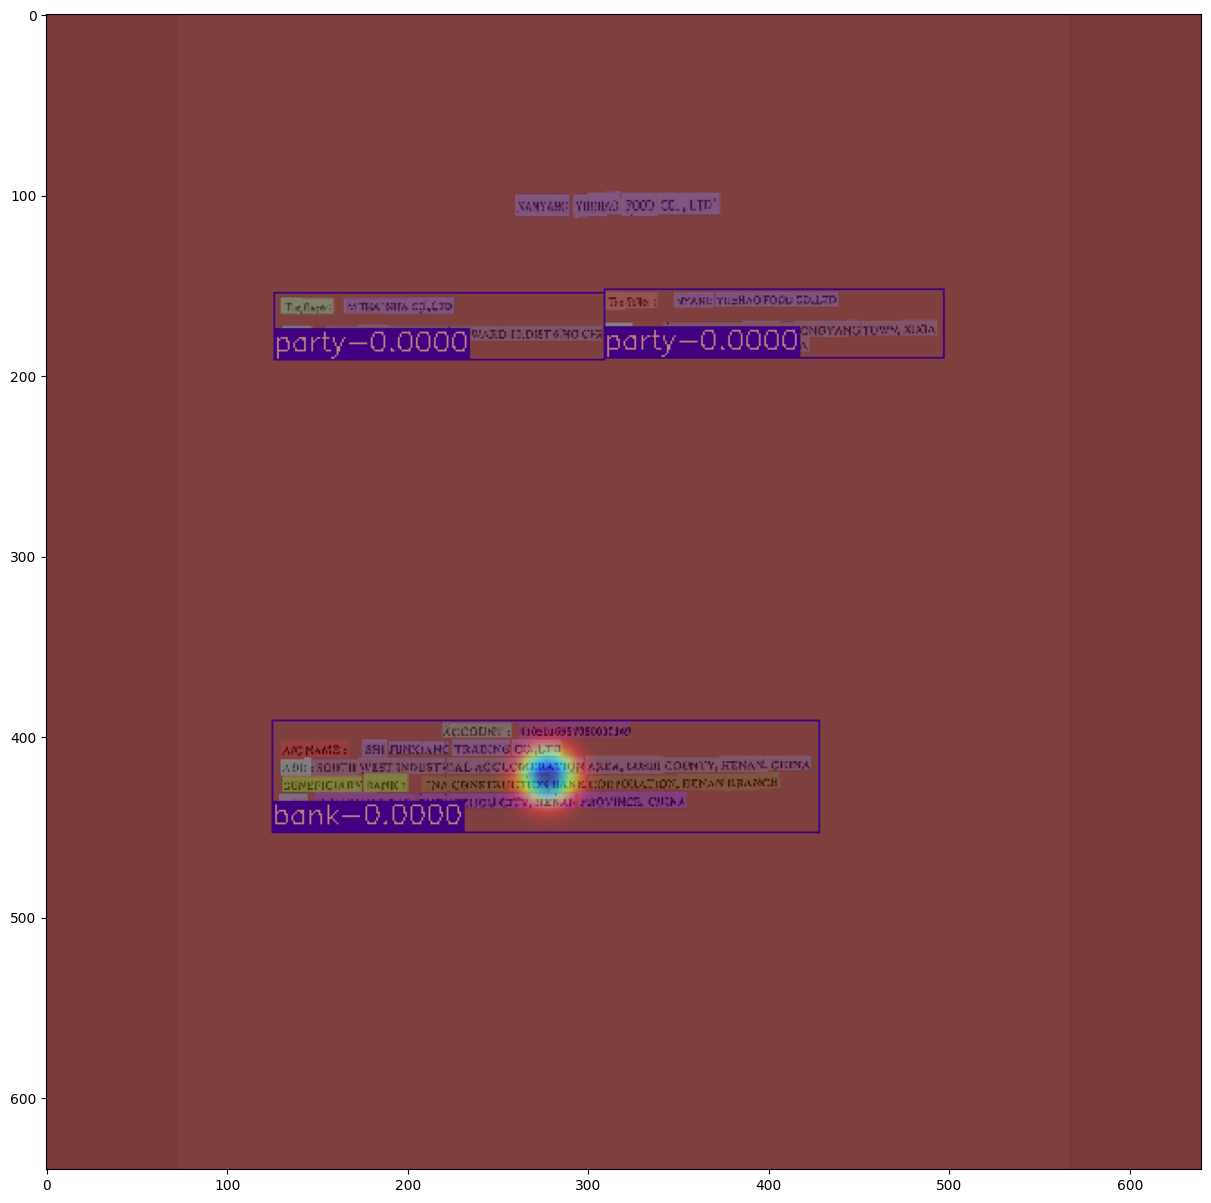

KeyboardInterrupt: Interrupted by user

In [2]:
from dataset.assigner import Assigner
from utils import parse_xml, Resizer
import yaml
import os
import cv2
import matplotlib.pyplot as plt

def draw_boxes(src_image, boxes, scores, labels):
    color = (0, 0, 255)
    for box, score, lb in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box.astype('int32')
        score = '{:.4f}'.format(score)
        label = '-'.join([lb, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return src_image

with open('config/contract_block.yaml') as f:
    cfg = yaml.safe_load(f)
    
path = cfg['val']
assigner = Assigner(num_classes=2, input_size=640, stride=4, max_object=100)
resizer = Resizer(size=(640, 640), mode='letterbox')
mapper = cfg['names']
for name in os.listdir(path):
    fp = os.path.join(path, name)
    xp = fp.replace('images', 'annotations').replace('.jpg', '.xml')
    img = cv2.imread(fp)
    boxes, obj_names = parse_xml(xp)
    class_ids = [mapper[obj_name] for obj_name in obj_names]
     
    resized = resizer.resize_image(img)
    new_boxes = resizer.resize_boxes(boxes, img.shape[:2])
    ## Vẽ cái box lên
    resized = draw_boxes(resized, new_boxes, [0]*len(new_boxes), obj_names)
    
    #Overlay cái thằng hm lên
    hm, whm, reg, indices = assigner(new_boxes, class_ids)
    
    # Heatmap check done [v]
    heat = cv2.applyColorMap((hm[..., 1]*255).astype('uint8'), cv2.COLORMAP_JET)
    heat = cv2.resize(heat, (640, 640))
    resized = cv2.addWeighted(resized, 0.5, heat.astype('uint8'), 0.5, 0.0)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(resized)
    plt.show()
    input()

## Check end-to-end generator

## Check model inference

In [4]:
#Check model infer
from model import Model
from dataset.assigner import Assigner
from utils import parse_xml, Resizer
from dataset.generator import Generator
import yaml
import os
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from time import time

def draw_boxes(src_image, boxes, scores, labels):
    color = (0, 0, 255)
    for box, score, lb in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box.astype('int32')
        score = '{:.4f}'.format(score)
        label = '-'.join([lb, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return src_image

with open('config/contract_block.yaml') as f:
    cfg = yaml.safe_load(f)
    
assigner = Assigner(num_classes=2, input_size=640, stride=4, max_object=100)
resizer = Resizer(size=(640, 640), mode='letterbox')

mapper = cfg['names']
model = Model(version=cfg['version'], nc=cfg['nc'], max_boxes=cfg['max_boxes'], is_training=False)
model.load_state_dict(torch.load('save_dir/contract_block/checkpoint-epoch100.pth')['state_dict'])
model.eval()
model.cuda()

Load successfully yolov8 backbone weights !


Model(
  (backbone): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1

In [6]:
# %matplotlib inline

path = cfg['val']
for name in os.listdir(path):
    fp = os.path.join(path, name)
    xp = fp.replace('images', 'annotations').replace('.jpg', '.xml')
    img = cv2.imread(fp)
    labels_boxes, labels_obj_names = parse_xml(xp)
    labels_class_ids = [mapper[obj_name] for obj_name in labels_obj_names]
    
    # resized, new_boxes = resizer(img, boxes)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = resizer.resize_image(img)
    tensor_in = resized.astype(np.float32) / 255.0
    tensor_in = np.expand_dims(np.transpose(tensor_in, (2, 0, 1)), 0)
    tensor_in = torch.from_numpy(tensor_in).cuda()
    # print(tensor_in.shape)
    ## Vẽ cái box lên
    # resized = draw_boxes(resized, new_boxes, [0]*len(new_boxes), obj_names)
    s = time()
    res = model(tensor_in)[0].cpu().detach().numpy()

    print(time() - s)
    boxes, scores, class_ids = res[:, :4], res[:, 4], res[:, 5]
    idxs = np.where(scores > 0.01)
    boxes = boxes[idxs] * 4
    scores = scores[idxs]
    class_ids = class_ids[idxs]    
    
    class_names = ['party' if c == 0 else 'bank' for c in class_ids]
    print(boxes, scores, class_ids)
    boxes = resizer.rescale_boxes(boxes, img.shape[:2])
    img = draw_boxes(img, boxes.astype('int32'), scores, class_names)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()
    input()

0.020760536193847656
[[        186           2         186           2]
 [        190           2         190           2]
 [        178           2         178           2]
 [        182           2         182           2]
 [         74           2          74           2]
 [         78           2          78           2]
 [         66           2          66           2]
 [         70           2          70           2]
 [        118           2         118           2]
 [        114           2         114           2]
 [        126           2         126           2]
 [        122           2         122           2]
 [         98           2          98           2]
 [        102           2         102           2]
 [        106           2         106           2]
 [        110           2         110           2]
 [         14           2          14           2]
 [         10           2          10           2]
 [          6           2           6           2]
 [        

KeyboardInterrupt: Interrupted by user

2023-04-10 07:45:26,603 - INFO - Loading labels from cache ...
2023-04-10 07:45:26,605 - INFO - Total: 33 | Images: 33 | Background: 0 | Empty: 0
0.02785468101501465
[[     120.38      508.29      339.52      552.42]
 [     123.61      59.516      471.75      104.12]
 [     290.81      58.104      465.54      112.58]
 [     131.03      58.393      288.64      103.81]] [    0.76933     0.44373     0.36426     0.25853] [          1           0           0           0]


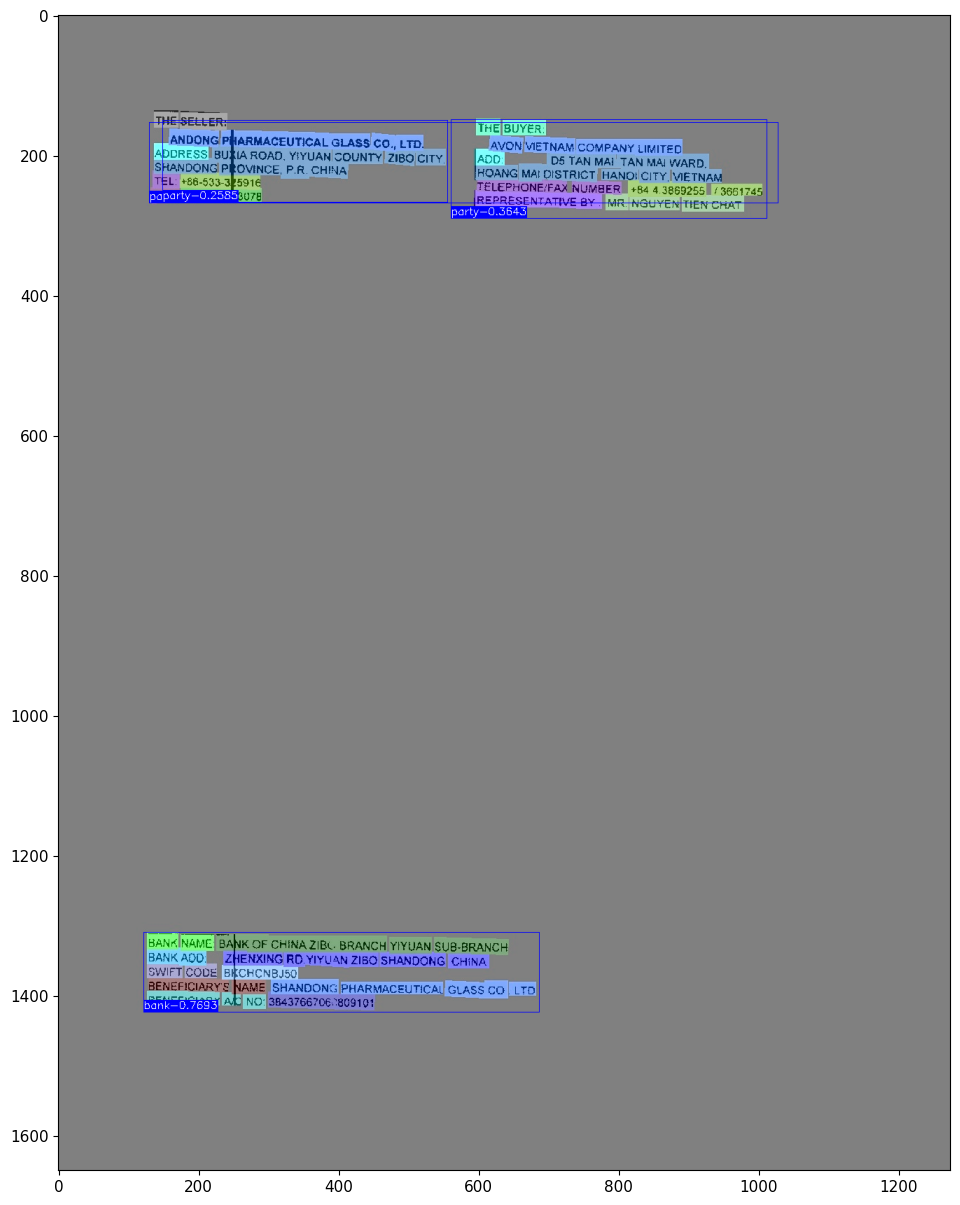

0.033490657806396484
[[     81.405      59.456       474.2      105.35]
 [     77.281      66.325      470.75      137.29]
 [     87.954      62.127      260.14      133.24]
 [     255.93      64.493      460.37      139.29]
 [     252.59      60.058      455.52       103.5]] [    0.58519     0.28368     0.19625     0.18047     0.12665] [          0           1           0           0           0]


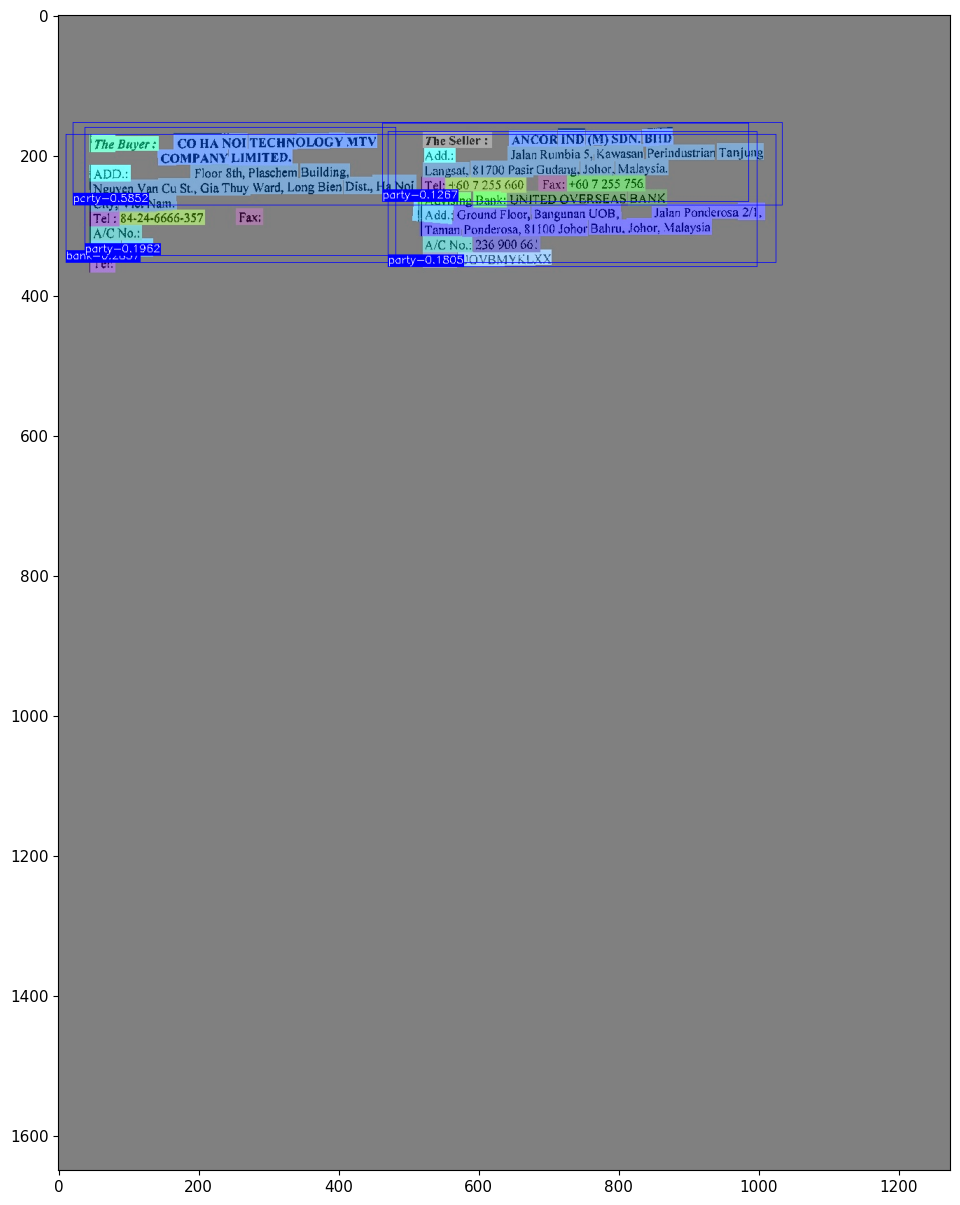

KeyboardInterrupt: Interrupted by user

In [27]:
test_dataset = Generator(cfg, mode='test')
for i, (data, target, im_path) in enumerate(test_dataset):
    # , (hm, wh, reg, indices), d['im_path']
    img = cv2.imread(im_path)
    tensor_in = np.expand_dims(np.transpose(data, (2, 0, 1)), 0)
    tensor_in = torch.from_numpy(tensor_in).cuda()
    # print(tensor_in.shape)
    ## Vẽ cái box lên
    # resized = draw_boxes(resized, new_boxes, [0]*len(new_boxes), obj_names)
    s = time()
    # res = model(tensor_in)[0].cpu().detach().numpy()
    out = model(tensor_in)
    res = model.decoder(out)[0].cpu().detach().numpy()

    print(time() - s)
    boxes, scores, class_ids = res[:, :4], res[:, 4], res[:, 5]
    idxs = np.where(scores > 0.1)
    boxes = boxes[idxs] * 4
    scores = scores[idxs]
    class_ids = class_ids[idxs]    
    
    class_names = ['party' if c == 0 else 'bank' for c in class_ids]
    print(boxes, scores, class_ids)
    boxes = resizer.rescale_boxes(boxes, img.shape[:2])
    img = draw_boxes(img, boxes.astype('int32'), scores, class_names)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()
    input()